In [2]:
import os
import sys
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import itertools
from collections import Counter
import pygraphviz
import psycopg2
from networkx.drawing.nx_agraph import graphviz_layout
from datetime import datetime


In [3]:
db = psycopg2.connect(user="lvs215",
                      password="",
                      host="127.0.0.1",
                      port="12777",
                      database="aip")

In [4]:
queries = [
    # The entire community - 0
    (
        """
        SELECT id
        FROM publications
        WHERE year between 2011 AND 2020
        """,
        "systems-community",
        "collaboration-network-systems-community_aip.gexf"
    ),

    # Workflow communities - 1
    (
        """
        SELECT id
        FROM publications
        WHERE year between 2011 AND 2020
        AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%')
        AND (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%')
        """,
        "workflow-community",
        "collaboration-network-workflow-scheduling_aip.gexf"
    ),

    # Workflow formalisms - 2
    (
        """
        SELECT id
        FROM publications
        WHERE year between 2011 AND 2020
        AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%')
        AND (
            (lower(title) LIKE '%formalism%' OR lower(abstract) LIKE '%formalism%')
            OR (lower(title) LIKE '%language%' OR lower(abstract) LIKE '%language%')
        )
        """,
        "workflow-formalism-community",
        "collaboration-network-workflow-formalisms_aip.gexf"
    ),

    # Workflow allocation - 3
    (
        """
        SELECT id
        FROM publications
        WHERE year between 2011 AND 2020
        AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%')
        AND (
            (lower(title) LIKE '%allocat%' OR lower(abstract) LIKE '%allocat%')
            OR (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%')
            OR (lower(title) LIKE '%plan%' OR lower(abstract) LIKE '%plan%')
        )
        """,
        "workflow-allocation-community",
        "collaboration-network-workflow-allocation_aip.gexf"
    ),

    # Resource provisioning communities - 4
    (
        """
        SELECT id
        FROM publications
        WHERE year between 2011 AND 2020
        AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%')
        AND (
            lower(title) LIKE '%provision%' OR lower(abstract) LIKE '%provision%'
            OR lower(title) LIKE '%autoscal%' OR lower(abstract) LIKE '%autoscal%'
        )
        """,
        "resource-provisioning-community",
        "collaboration-network-resource-provisioning_aip.gexf"
    ),

    # applications and services - 5
    (
        """
        SELECT id
        FROM publications
        WHERE year between 2011 AND 2020
        AND (lower(title) LIKE '%cloud%' OR lower(abstract) LIKE '%cloud%')
        AND (lower(title) LIKE '%service%' OR lower(abstract) LIKE '%service%')
        """,
        "applications-and-services-community",
        "collaboration-network-applications-and-services-community_aip.gexf"
    ),
]

In [5]:
def generate_graph_for_publication_query(search_query, file_name):
    query = """
    SELECT a.id, a.name, app.paper_id 
    FROM authors a JOIN author_paper_pairs app ON CAST(a.id AS VARCHAR) = app.author_id
    WHERE app.paper_id IN (
        {}
    ) ORDER BY app.paper_id""".format(search_query)

    with db.cursor() as cursor:
        cursor.execute(query)
        author_list = cursor.fetchall()

    g = nx.Graph()
    author_set = set()
    author_id_to_label = dict()
    author_relation_set = set()
    author_list_len = len(author_list)
    i = 0

    num_relations = 0
    num_articles = 0
    while i < author_list_len:
        author_id = author_list[i][0]
        author_name = author_list[i][1]
        paper_id = author_list[i][2]
        num_articles += 1

        if author_id not in author_set:
            author_set.add(author_id)
            author_id_to_label[author_id] = author_name
            g.add_node(author_id, label=author_name)

        # Make sure to loop from i+1, to avoid self-loops yet still capture the many-to-many relationship
        for j in range(i + 1, len(author_list)):
            co_author_id = author_list[j][0]
            co_author_name = author_list[j][1]
            co_paper_id = author_list[j][2]

            # Check if we reached a new article
            if co_paper_id != paper_id:
                break

            if co_author_id not in author_set:
                author_set.add(co_author_id)
                author_id_to_label[co_author_id] = co_author_name
                g.add_node(co_author_id, label=co_author_name)

            num_relations += 1
            # Put a relation of (smallest id, larger id) to only add an edge once later.
            # Doing this ensures we do not add a relationship more than once.
            if (min(author_id, co_author_id),
                max(author_id, co_author_id)) not in author_relation_set:
                author_relation_set.add((min(author_id, co_author_id),
                                         max(author_id, co_author_id)))
                g.add_edge(min(author_id, co_author_id),
                           max(author_id, co_author_id))
        i += 1

    print(
        "query: {}, number of articles: {}, number authors in field: {}, number of relationships: {}, number of unique relationships: {}".format(
            search_query, num_articles, len(author_set), num_relations,
            len(author_relation_set)))
    nx.write_gexf(g, file_name)
    return g

In [6]:
def visualize_cliques_numbers_in_graph(g, community_string):
    minimum_clique_size = 1
    cliques = list(
        x for x in nx.find_cliques(g) if len(x) >= minimum_clique_size)

    cliques_counter = Counter([len(c) for c in cliques])
    print(
        "Number of cliques with minimum size of {}: {} community string: {}".format(
            minimum_clique_size, len(cliques), community_string))
    print("Largest clique: {}".format(max(cliques_counter.keys())))

    # for i in range(len(cliques)):
    #     if len(cliques[i]) < 100:
    #         continue
    #     print("Clique {} with {} members:".format(i+1, len(cliques[i])))
    #     print(", ".join([author_id_to_label[author_id] for author_id in cliques[i]]))
    #     print()

    # Create a bargraph on the distribution of cliques
    fig, ax = pl.subplots(figsize=(16, 16))
    ax.bar(cliques_counter.keys(), cliques_counter.values())

    if max(cliques_counter.keys()) < 50:  # We can probaby visualize this without text above the bars overlapping
        max_y_value = ax.get_ylim()[1]
    #         text_margin = max_y_value / 100
    #         for key, value in cliques_counter.items():
    #             ax.text(key, value + text_margin, str(value), color='black', ha='center', fontweight='normal', fontsize=28)
    else:  # Zooms in on the lower axis to show the small 
        # Inner Plot
        inner_ax = fig.add_axes([0.21, 0.2, 0.67, 0.4])  # x, y, width, height
        inner_ax.bar(cliques_counter.keys(), cliques_counter.values())

        ylim = 10
        text_margin = ylim / 100

        inner_ax.set(title='Zoom In', xlim=(0, 300), ylim=(0, ylim))
        #         for key, value in cliques_counter.items():
        #             if value < ylim:
        #                 inner_ax.text(key, value + text_margin, str(value), color='black', ha='center', fontweight='normal', fontsize=26)

        # Set the fontsize of the inner plot
        for item in ([inner_ax.title, inner_ax.xaxis.label,
                      inner_ax.yaxis.label] + inner_ax.get_xticklabels() + inner_ax.get_yticklabels()):
            item.set_fontsize(26)

        # We manually set the visibility of the lines from the original graph to the zoomed in part
        # as MatplotLib is choosing slightly akward lines itself.
        patch, connector_lines = ax.indicate_inset_zoom(inner_ax)
        connector_lines[0].set_visible(True)
        connector_lines[1].set_visible(False)
        connector_lines[2].set_visible(True)
        connector_lines[3].set_visible(False)

    ax.set_xlabel("Clique size", fontsize=40)
    ax.set_ylabel("Number of cliques", fontsize=40)

    for item in ([ax.title, ax.xaxis.label,
                  ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(34)

    date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    fig.savefig('cliques_{}_{}.pdf'.format(community_string, date_time))

In [7]:
def visualize_graph_using_radial_trees(g, community_string):
    # Remove all subgraphs that have a size less than 5
    nodes_to_remove = set()
    for c in nx.connected_components(g):
        subgraph = g.subgraph(c)
        if subgraph.number_of_nodes() < 5:
            for node in subgraph:
                nodes_to_remove.add(node)

    for node in nodes_to_remove:
        g.remove_node(node)

    pos = graphviz_layout(g, prog='twopi')
    #     pos = graphviz_layout(g, prog='sfdp')
    plt.figure(figsize=(16, 16))
    nx.draw(g, pos, node_size=20, alpha=0.5, node_color='blue',
            with_labels=False)
    plt.axis('equal')
    date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    plt.savefig('radial-trees_{}_{}.pdf'.format(community_string, date_time))

In [8]:
# For debugging: grab a query that runs fast and tailor the graphs by just running the next cell
search_query, community_string, graph_file_name = queries[4]
graph = generate_graph_for_publication_query(search_query, graph_file_name)

query: 
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        lower(title) LIKE '%provision%' OR lower(abstract) LIKE '%provision%' 
        OR lower(title) LIKE '%autoscal%' OR lower(abstract) LIKE '%autoscal%'
    )
    , number of articles: 395, number authors in field: 317, number of relationships: 753, number of unique relationships: 694


Number of cliques with minimum size of 1: 85 community string: resource-provisioning-community
Largest clique: 11


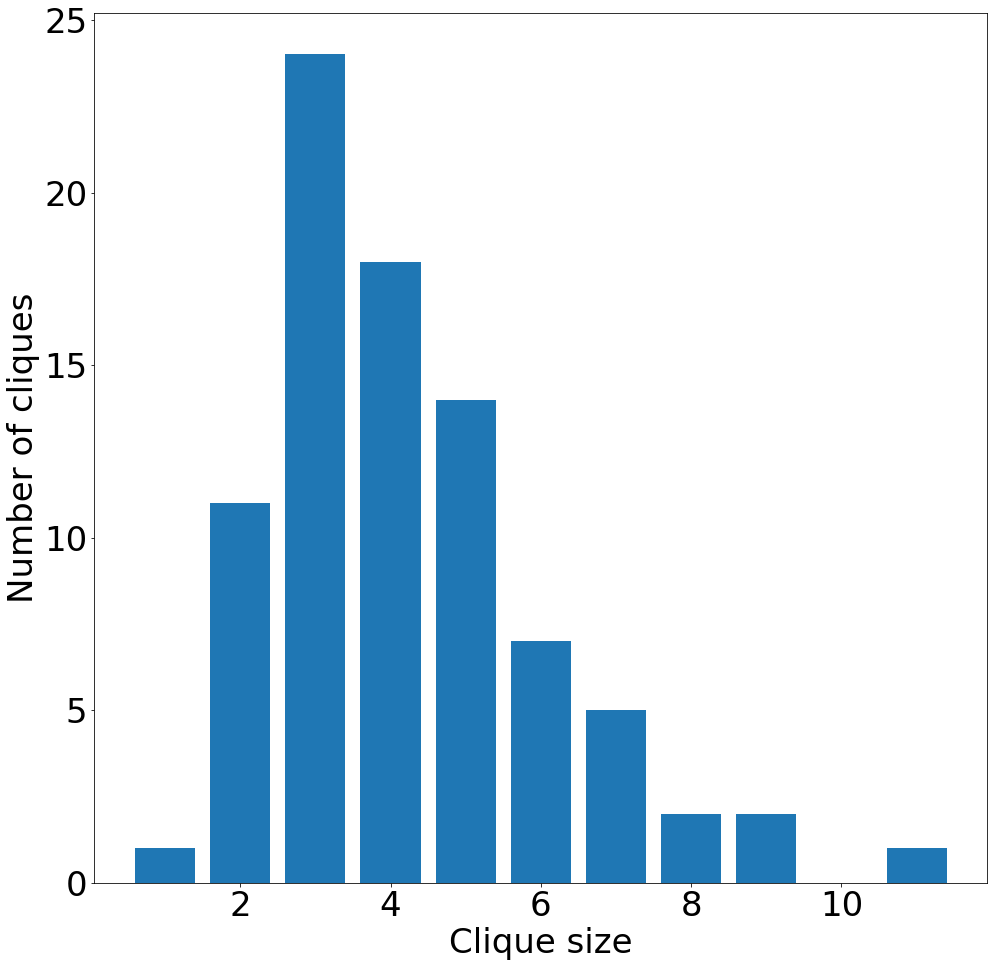

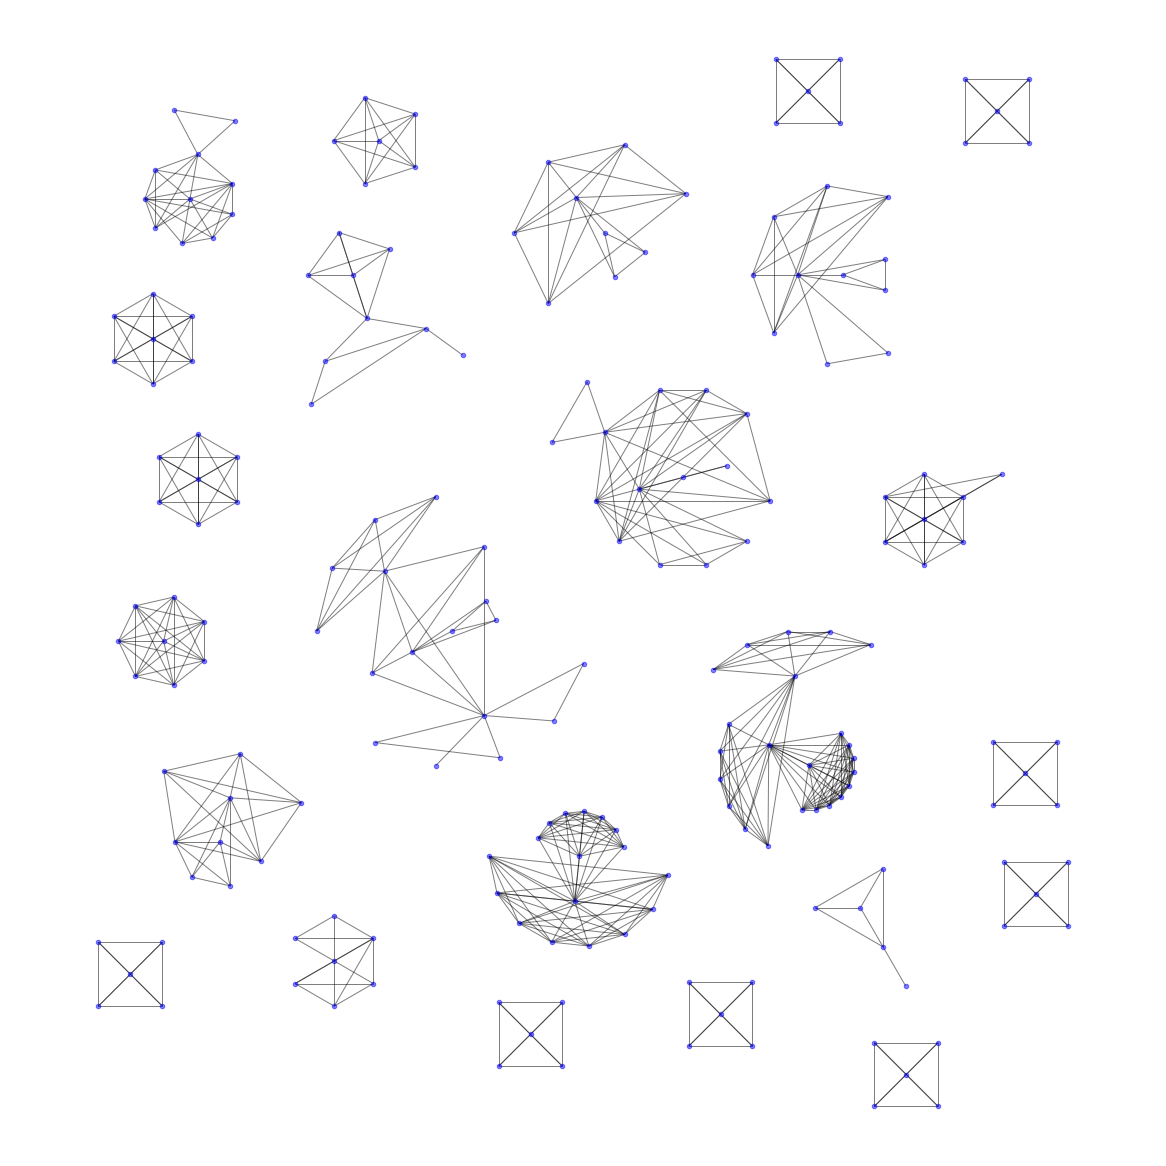

In [9]:
# Debug cell for the output of the previous cell
visualize_cliques_numbers_in_graph(graph, community_string)
visualize_graph_using_radial_trees(graph, community_string)

In [10]:
# Loops through all the queries and generates bar plots and community graphs data
graphs_per_community = dict()
for search_query, community_string, graph_file_name in queries:
    graph = generate_graph_for_publication_query(search_query, graph_file_name)
    graphs_per_community[community_string] = graph

query: 
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    , number of articles: 187398, number authors in field: 81468, number of relationships: 371309, number of unique relationships: 291425
query: 
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%')
    , number of articles: 994, number authors in field: 739, number of relationships: 2024, number of unique relationships: 1826
query: 
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        (lower(title) LIKE '%formalism%' OR lower(abstract) LIKE '%formalism%') 
        OR (lower(title) LIKE '%language%' OR lower(abstract) LIKE '%language%')
    )
    , number of articles: 290, number authors in field: 275, number of r

Number of cliques with minimum size of 1: 42604 community string: systems-community
Largest clique: 79
Number of cliques with minimum size of 1: 206 community string: workflow-community
Largest clique: 15
Number of cliques with minimum size of 1: 60 community string: workflow-formalism-community
Largest clique: 22
Number of cliques with minimum size of 1: 277 community string: workflow-allocation-community
Largest clique: 22
Number of cliques with minimum size of 1: 85 community string: resource-provisioning-community
Largest clique: 11
Number of cliques with minimum size of 1: 3234 community string: applications-and-services-community
Largest clique: 33


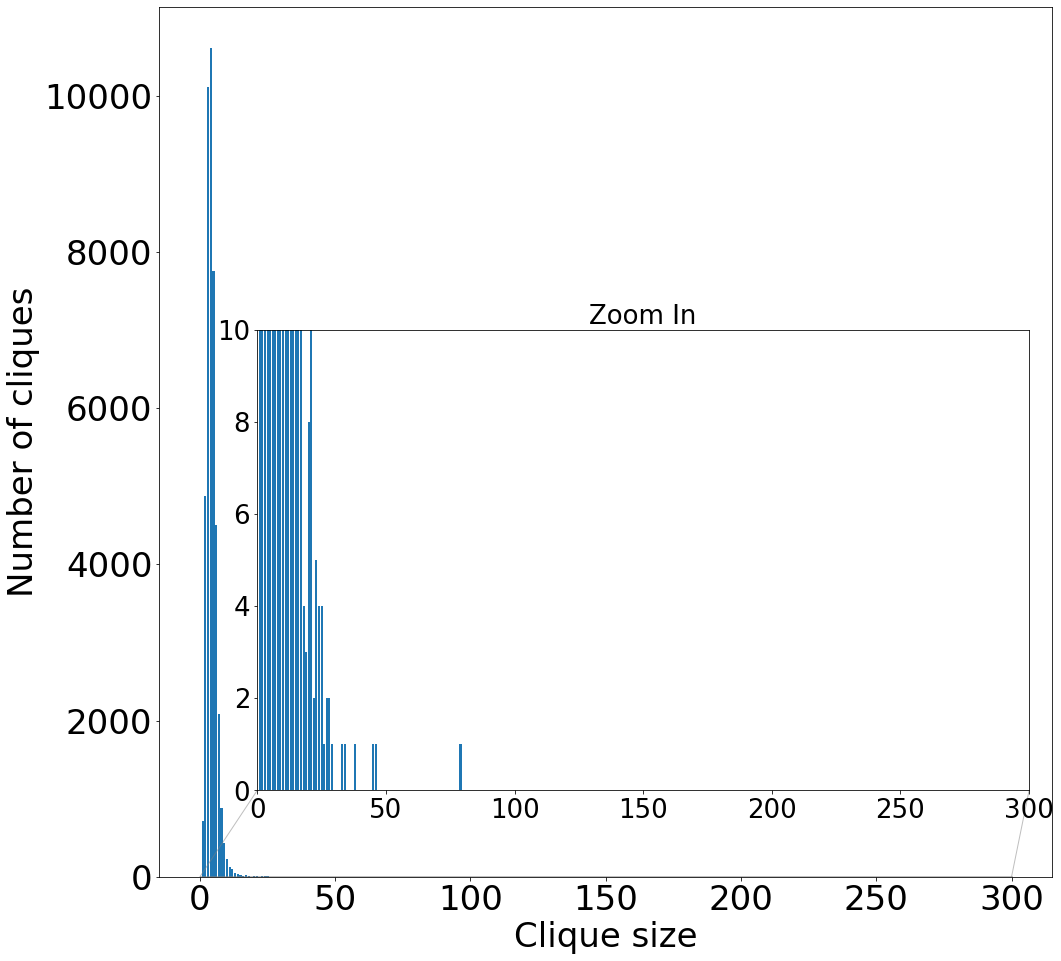

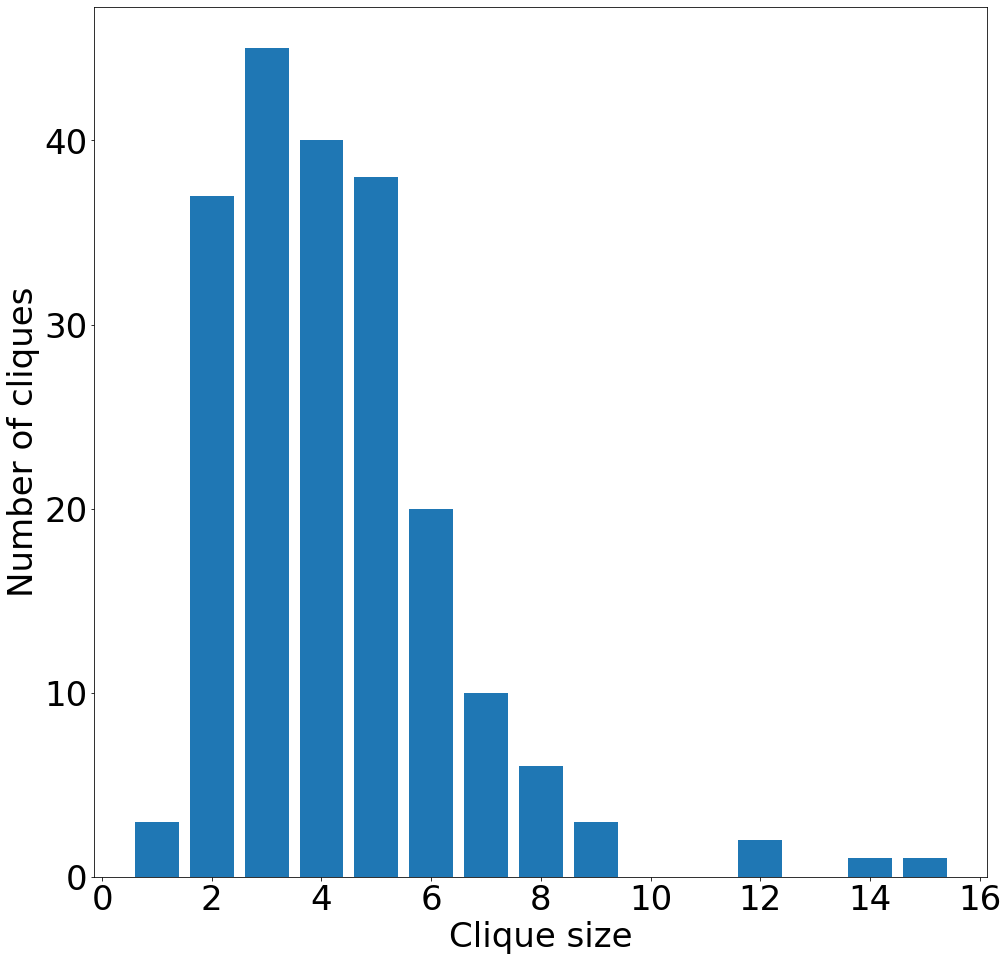

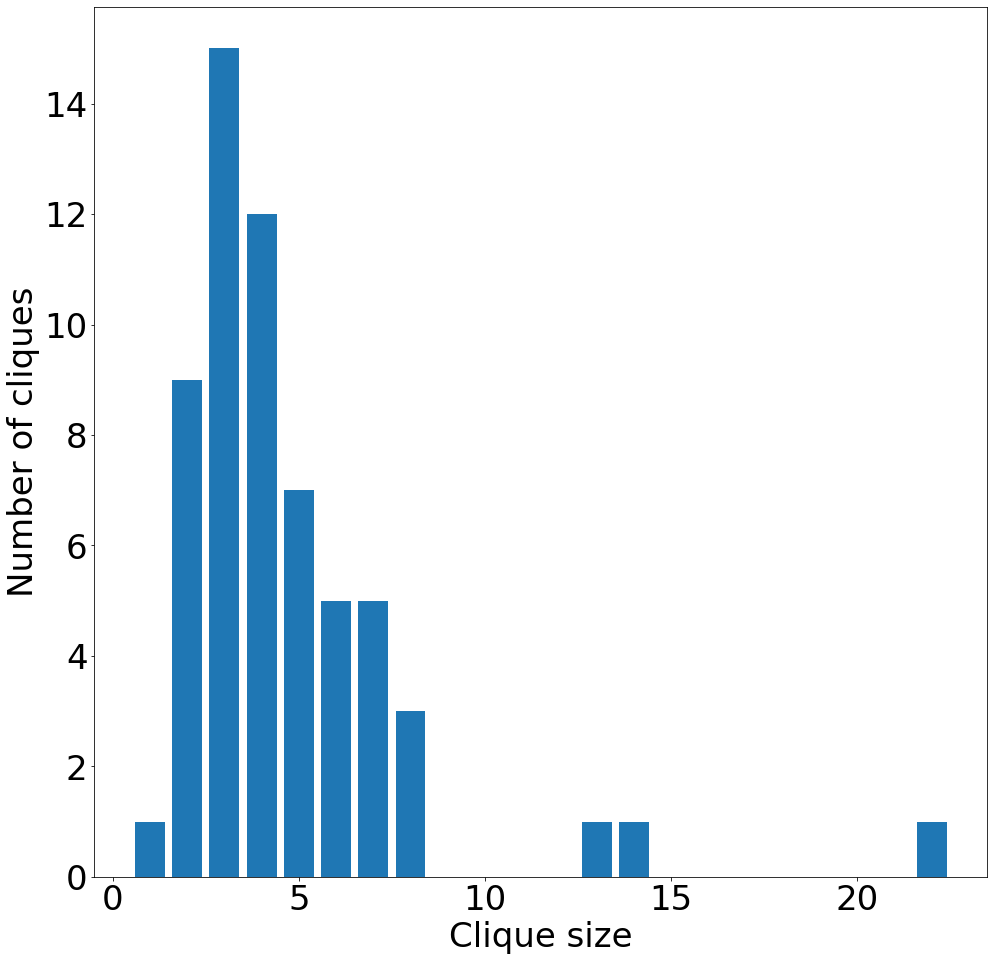

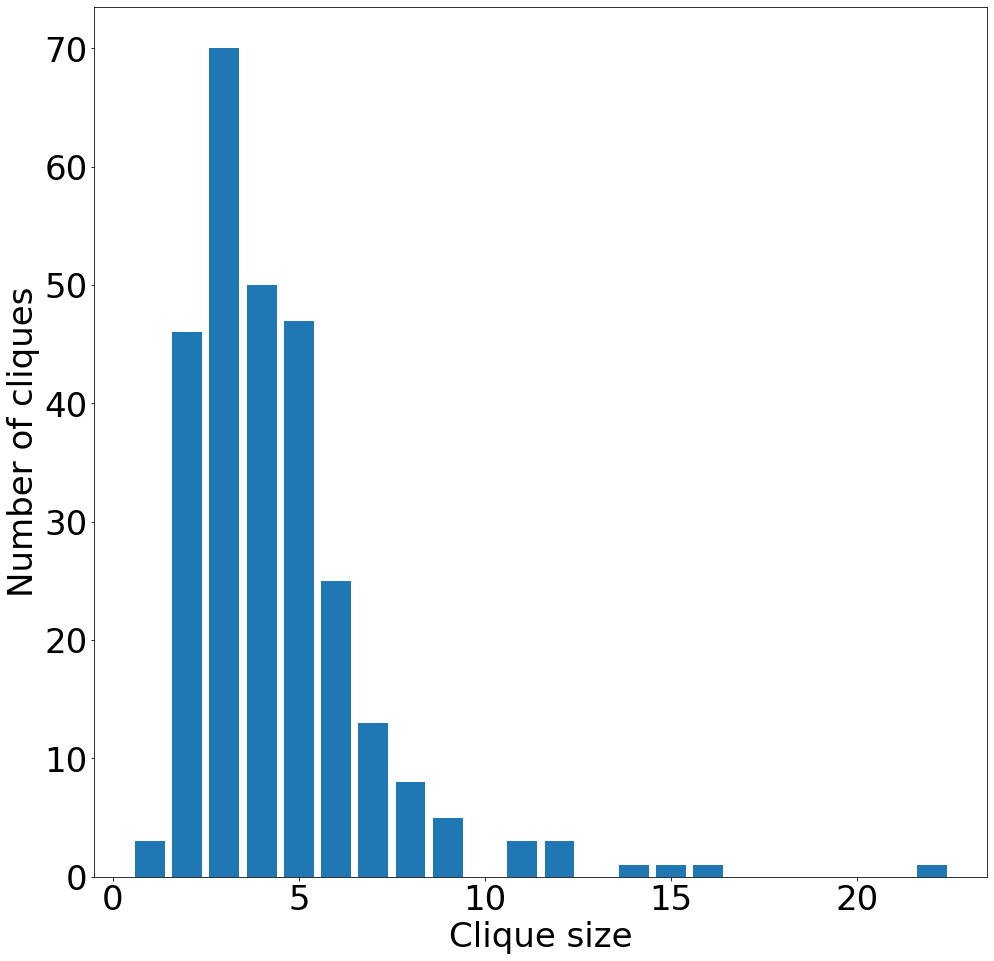

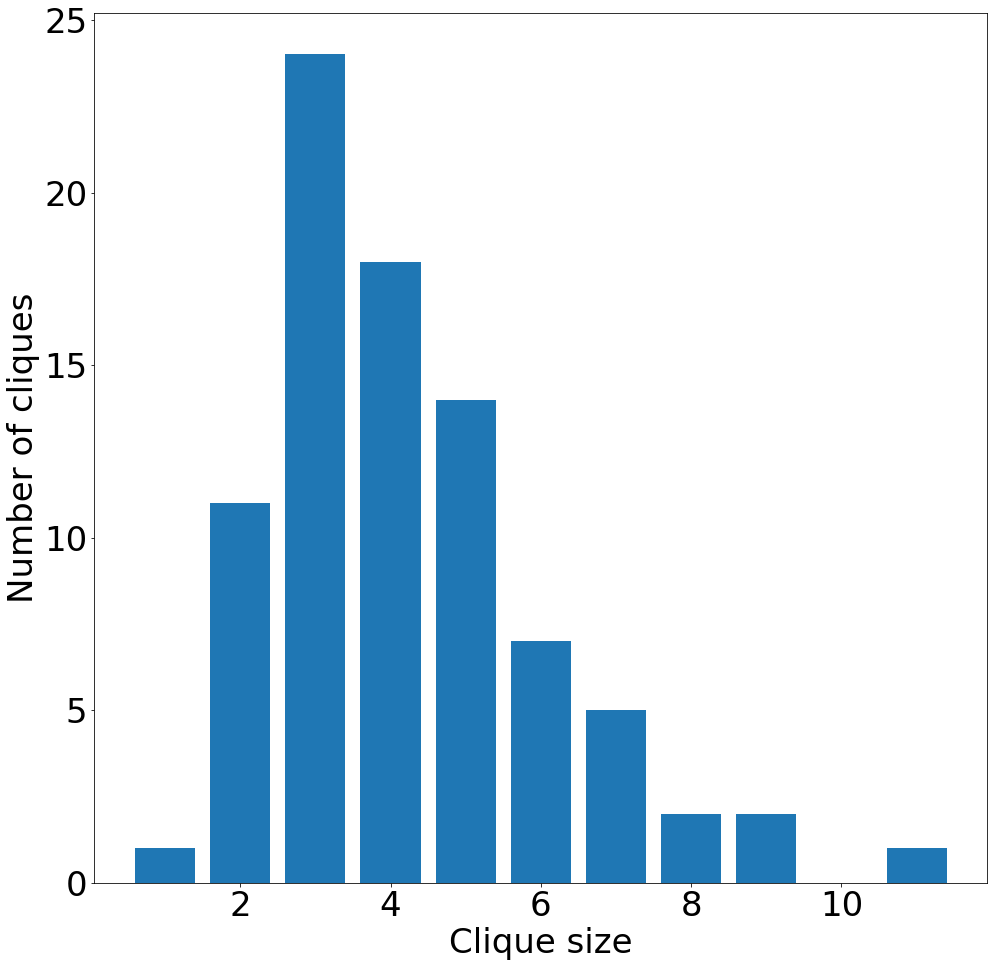

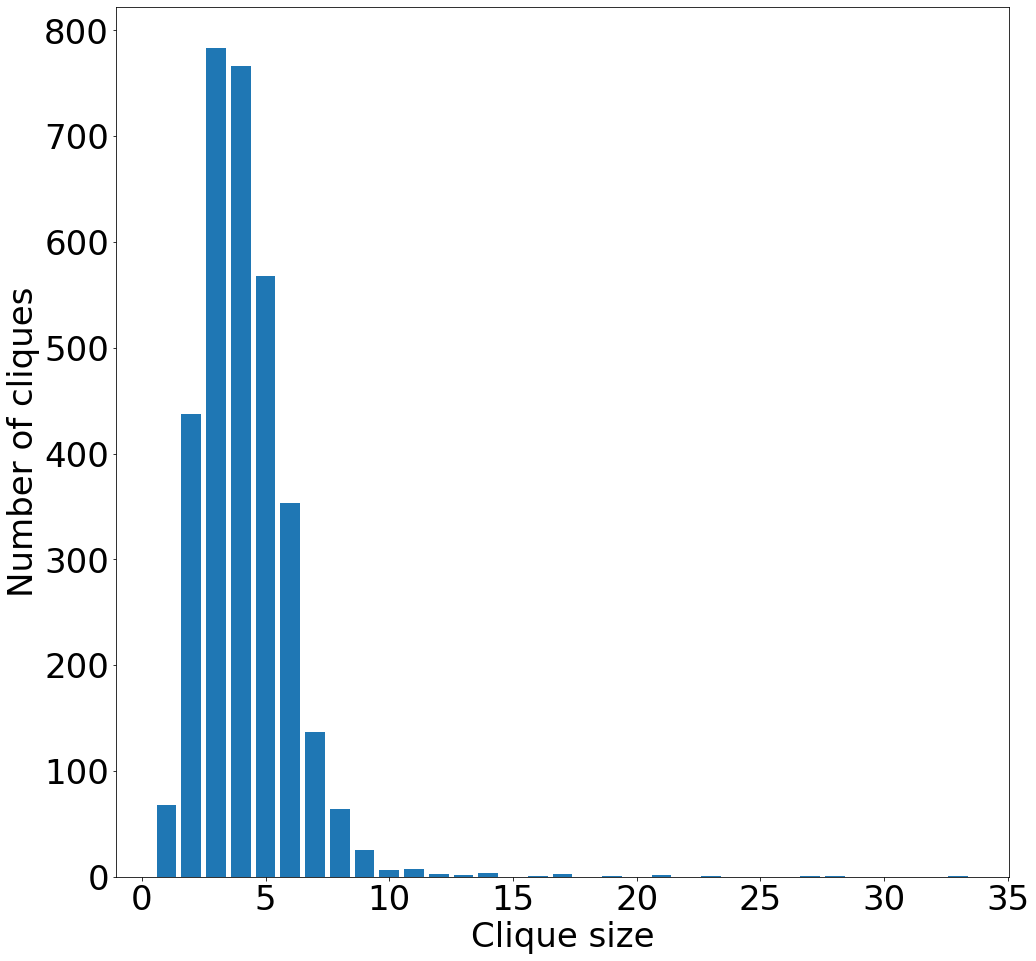

In [11]:
# Outputs the bar plots and community graphs based on the data from the previous cell

for community_string, graph in graphs_per_community.items():
    visualize_cliques_numbers_in_graph(graph, community_string)
    #visualize_graph_using_radial_trees(graph, community_string)

In [ ]:
# Verification code for the largest clique. Requires heavy crunching! 

# largest_clique = sorted(cliques, key=len)[-1]
# all_co_authors = set()
# co_authors_per_id = dict()

# for author_id in largest_clique:
#     query = """
# SELECT DISTINCT a.id
# FROM publications p JOIN author_paper_pairs app ON app.paper_id = p.id JOIN authors a on a.id = app.author_id
# WHERE p.id IN (
# 	SELECT p.id
# 	FROM publications p JOIN author_paper_pairs app ON app.paper_id = p.id JOIN authors a on a.id = app.author_id
# 	WHERE a.id = ?
# )
# """
#     query_result = cursor.execute(query, [author_id])
#     author_list = query_result.fetchall()
#     co_author_set = set()
#     for row in author_list:
#         co_author_set.add(row[0])
#     co_authors_per_id[author_id] = co_author_set
#     all_co_authors = all_co_authors.union(co_author_set)

# print(len(all_co_authors))
# clique_to_set = set(largest_clique)
# print(clique_to_set.issubset(all_co_authors))
# for author_id, co_author_set in co_authors_per_id.items():
#     print(clique_to_set.issubset(co_author_set))

In [ ]:
# OLD CODE - Prints the LaTeX dual figure with left the community visualization plot and right the clique count bar plot
for community_string in graphs_per_community.keys():
    print(r"""
    \begin{{figure}}
        \centering
        \begin{{subfigure}}[t]{{0.49\textwidth}}
            \includegraphics[width=\textwidth]{{figures/radial-trees_{0}.png}}
            \caption{{A visual representation of the {1}. Only subgraphs with cardinality 5 or higher are shown.}}
            \label{{fig:overview-{0}}}
        \end{{subfigure}}~
        \begin{{subfigure}}[t]{{0.49\textwidth}}
            \includegraphics[width=\textwidth]{{figures/cliques_{0}.png}}
            \caption{{A bar plot depicting the size and number of cliques within the {1}.}}
            \label{{fig:cliques-{0}}}
        \end{{subfigure}}
        \caption{{An overview of the {1}.}}\label{{fig:{0}}}
    \end{{figure}}
    """.format(community_string, community_string.replace("-", " "))
          )